In [ ]:
!pip install pennylane

Import all the essecsial library

In [ ]:
import pennylane as qml
# Just like standard NumPy, but with the added benefit of automatic differentiation
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras import metrics
import time
import random

In [ ]:
n_epochs = 30
n_layers = 1
n_train = 500
n_test = 200

SAVE_PATH = "/content/"
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images1 = train_images / 255
test_images1 = test_images / 255

# Add extra dimension (for convolution channels)
train_images = np.array(train_images1[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images1[..., tf.newaxis], requires_grad=False)

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(500, 28, 28, 1)
(500,)
(200, 28, 28, 1)
(200,)


In [ ]:
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))


@qml.qnode(dev)
def circuit(phi):
    # Apply a rotation gate RY on each wire
    for i in range(4):
        qml.RY(phi[i], wires=i)

    # Apply CZ gate between wire 0 and wire 1
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[1, 2])

    qml.SWAP(wires=[0, 1])
    qml.SWAP(wires=[2, 3])

    qml.CNOT(wires=[1, 2])
    qml.Hadamard(wires=1)

    # Apply CZ gate between wire 2 and wire 3
    #qml.CRY(phi[p], wires=[0, 1])
    #qml.RY(phi[q], wires=[2, 3])

    # Measurement: returning the expectation value of PauliZ on each wire
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit"""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a 2x2 region with the quantum circuit
            q_results = circuit(
                [image[j, k, 0], image[j, k + 1, 0],
                 image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
def create_model():
    """Creates a Keras model that mimics processing of 4 pixels at a time in an ANN."""
    model = Sequential([
        # Flatten the entire image to a single vector
        Reshape((784,), input_shape=(28, 28, 1)),

        # Dense layer to mimic the 'circuit' applied to every group of four pixels
        # This example assumes a simple transformation that can be learned by a Dense layer
        # We simulate this by first reshaping the input to separate groups of 4 pixels
        Reshape((196, 4)),  # Now we have 196 groups of 4 pixels each
        Dense(4, activation='relu'),  # Apply a Dense transformation to each group of 4 pixels

        # Reshape back to a 14x14 feature map with 4 channels for further processing
        Reshape((14, 14, 4)),

    ])

    return model


In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx + 1}/{n_train}        ", end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx + 1}/{n_test}        ", end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


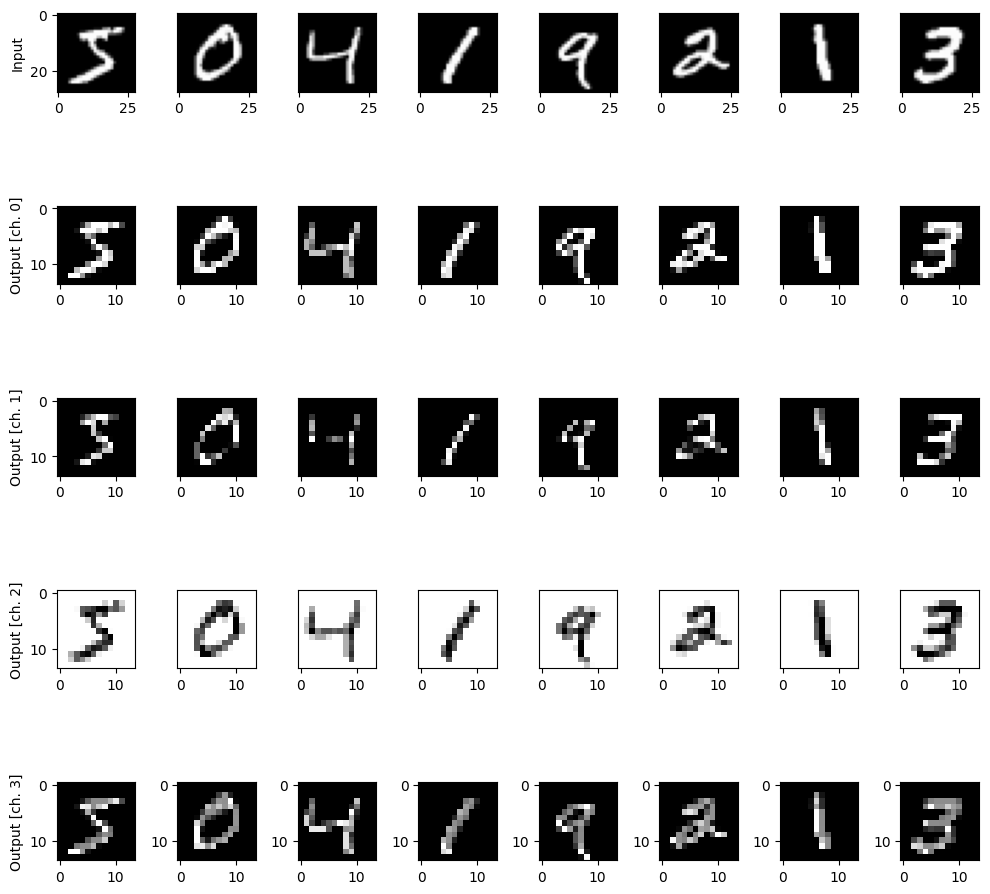

In [ ]:
n_samples = 8
n_channels = 4

fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f'out_q_layer_{n_samples}_samples.png', dpi=300, facecolor='w')
plt.show()

In [ ]:
def model():
    """Initializes and returns a Keras model to be trained"""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'],
    )
    return model

In [ ]:
import keras
from keras import layers, metrics

import keras
from keras import layers

def model1():
    """Initializes and returns a Keras model based on the LeNet-5 architecture"""
    model1 = keras.models.Sequential([
        # Resizing the 28x28 image to 32x32 by padding
        layers.ZeroPadding2D(padding=2, input_shape=(28, 28, 1)),
        # First convolution layer
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh'),
        # Average pooling layer
        layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        # Second convolution layer
        layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
        # Average pooling layer
        layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        # Flattening the output of the pooling layer to feed into the dense layer
        layers.Flatten(),
        # Dense layers
        layers.Dense(units=120, activation='tanh'),
        layers.Dense(units=84, activation='tanh'),
        # Output layer with softmax activation for classification
        layers.Dense(units=10, activation='softmax')
    ])

    model1.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        )
    return model1

In [ ]:
q_model = model()
start_time = time.time()
q_history = q_model.fit(q_train_images, train_labels,
                        validation_data=(q_test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)
q_time = time.time() - start_time
print(f"Training time: {q_time:.2f} seconds")

Epoch 1/30
125/125 - 1s - loss: 1.8479 - accuracy: 0.4440 - val_loss: 1.4781 - val_accuracy: 0.6050 - 1s/epoch - 9ms/step
Epoch 2/30
125/125 - 0s - loss: 1.1413 - accuracy: 0.7560 - val_loss: 1.1037 - val_accuracy: 0.7300 - 370ms/epoch - 3ms/step
Epoch 3/30
125/125 - 0s - loss: 0.8208 - accuracy: 0.8260 - val_loss: 0.9566 - val_accuracy: 0.7350 - 368ms/epoch - 3ms/step
Epoch 4/30
125/125 - 0s - loss: 0.6568 - accuracy: 0.8780 - val_loss: 0.8157 - val_accuracy: 0.7950 - 296ms/epoch - 2ms/step
Epoch 5/30
125/125 - 0s - loss: 0.5522 - accuracy: 0.8780 - val_loss: 0.7843 - val_accuracy: 0.7450 - 293ms/epoch - 2ms/step
Epoch 6/30
125/125 - 0s - loss: 0.4736 - accuracy: 0.9100 - val_loss: 0.7160 - val_accuracy: 0.7950 - 303ms/epoch - 2ms/step
Epoch 7/30
125/125 - 0s - loss: 0.4222 - accuracy: 0.9100 - val_loss: 0.6592 - val_accuracy: 0.8050 - 298ms/epoch - 2ms/step
Epoch 8/30
125/125 - 0s - loss: 0.3822 - accuracy: 0.9220 - val_loss: 0.5999 - val_accuracy: 0.8600 - 379ms/epoch - 3ms/step
Epo

##For quantum model, validation accuracy is 86.50% and it takes 20.90 second to train.


In [ ]:
c_model = model1()
start_time = time.time()
c_history = c_model.fit(train_images1, train_labels,
                        validation_data=(test_images1, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)
c_time = time.time() - start_time
print(f"Training time: {c_time:.2f} seconds")

Epoch 1/30
125/125 - 3s - loss: 1.1533 - accuracy: 0.6460 - val_loss: 0.6114 - val_accuracy: 0.7950 - 3s/epoch - 23ms/step
Epoch 2/30
125/125 - 0s - loss: 0.4738 - accuracy: 0.8480 - val_loss: 0.4898 - val_accuracy: 0.8500 - 455ms/epoch - 4ms/step
Epoch 3/30
125/125 - 0s - loss: 0.3275 - accuracy: 0.8960 - val_loss: 0.4212 - val_accuracy: 0.8550 - 444ms/epoch - 4ms/step
Epoch 4/30
125/125 - 1s - loss: 0.2567 - accuracy: 0.9140 - val_loss: 0.3404 - val_accuracy: 0.9050 - 510ms/epoch - 4ms/step
Epoch 5/30
125/125 - 0s - loss: 0.1669 - accuracy: 0.9520 - val_loss: 0.3963 - val_accuracy: 0.8650 - 450ms/epoch - 4ms/step
Epoch 6/30
125/125 - 0s - loss: 0.1072 - accuracy: 0.9760 - val_loss: 0.2934 - val_accuracy: 0.9000 - 452ms/epoch - 4ms/step
Epoch 7/30
125/125 - 0s - loss: 0.0632 - accuracy: 0.9900 - val_loss: 0.2785 - val_accuracy: 0.9300 - 436ms/epoch - 3ms/step
Epoch 8/30
125/125 - 0s - loss: 0.0495 - accuracy: 0.9960 - val_loss: 0.2898 - val_accuracy: 0.9250 - 452ms/epoch - 4ms/step
Ep

#For classical Lenet-5 model, validation accuracy is 92.50% and it takes 21.30 second to train.

#Time to run this code is

In [ ]:
# Record the start time for prediction
start_time = time.time()

# Make predictions
predictions = c_model.predict(test_images1)

# Record the end time for prediction
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time
print(f"Prediction took {prediction_time:.2f} seconds")

7/7 [==============================] - 0s 15ms/step
Prediction took 0.33 seconds


#Classical model takes 0.33 seconds for prediction.

In [ ]:
# Record the start time for prediction
start_time = time.time()

# Make predictions
predictions = q_model.predict(test_images)

# Record the end time for prediction
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time
print(f"Prediction took {prediction_time:.2f} seconds")

7/7 [==============================] - 0s 2ms/step
Prediction took 0.11 seconds


#Quantum model takes 0.11 seconds for prediction

<ipython-input-17-07dacc7673cc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


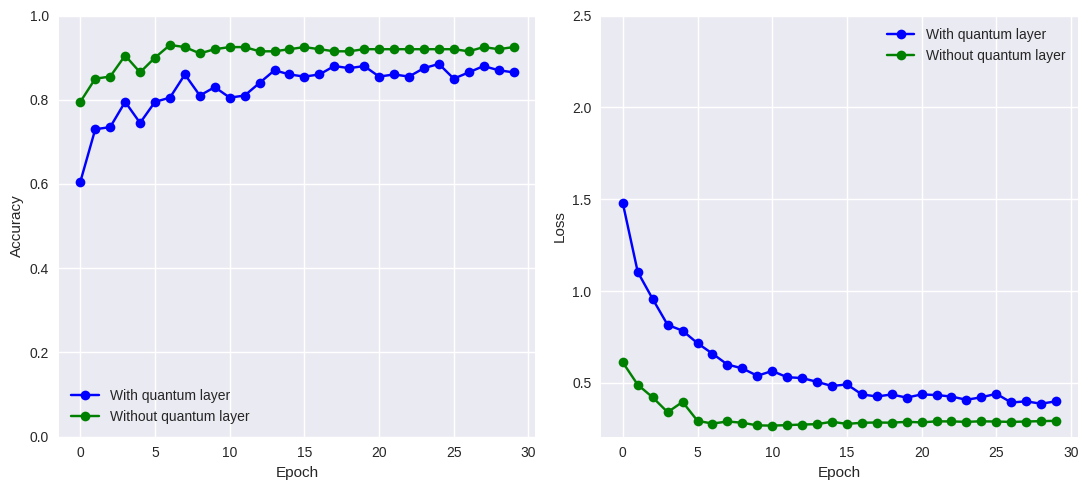

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png', dpi=200, facecolor='w')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import keras

# Assuming c_model is your trained model and test_images1, test_labels are your test data and labels

# Step 1: Predict the classes for the test data
# This will give you the indices of the most likely classes predicted by the model
predictions = c_model.predict(test_images1)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Compute the confusion matrix
# Ensure that test_labels are in the correct format, i.e., a flat array of integers
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Print or return the confusion matrix
print(conf_matrix)


7/7 [==============================] - 0s 2ms/step
[[17  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  1  0  0  0  0  0]
 [ 0  1  0 14  0  1  0  0  0  0]
 [ 0  0  0  0 26  0  1  0  0  1]
 [ 0  0  1  0  1 17  0  1  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  1  1  0  0  0 20  0  2]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  1  0  0  0  1  1 18]]


In [ ]:
predictions = q_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Compute the confusion matrix
# Ensure that test_labels are in the correct format, i.e., a flat array of integers
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Print or return the confusion matrix
print(conf_matrix)

7/7 [==============================] - 0s 2ms/step
[[ 1  0 16  0  0  0  0  0  0  0]
 [14  0 14  0  0  0  0  0  0  0]
 [ 4  0 11  0  1  0  0  0  0  0]
 [11  0  5  0  0  0  0  0  0  0]
 [26  0  1  0  1  0  0  0  0  0]
 [ 8  0 12  0  0  0  0  0  0  0]
 [14  0  6  0  0  0  0  0  0  0]
 [22  0  1  1  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [18  0  1  0  2  0  0  0  0  0]]


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import keras

# Assuming c_model is your trained model and test_images1, test_labels are your test data and labels

# Step 1: Predict the classes for the test data
predictions = c_model.predict(test_images1)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Compute the classification report
# Ensure that test_labels are in the correct format, i.e., a flat array of integers
# If test_labels are one-hot encoded, convert them: test_labels = np.argmax(test_labels, axis=1)
report = classification_report(test_labels, predicted_classes)

# Print or return the classification report
print(report)


7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.97      1.00      0.98        28
           2       0.88      0.94      0.91        16
           3       0.88      0.88      0.88        16
           4       0.93      0.93      0.93        28
           5       0.94      0.85      0.89        20
           6       0.95      1.00      0.98        20
           7       0.91      0.83      0.87        24
           8       0.91      1.00      0.95        10
           9       0.86      0.86      0.86        21

    accuracy                           0.93       200
   macro avg       0.92      0.93      0.92       200
weighted avg       0.92      0.93      0.92       200



In [ ]:
# Step 1: Predict the classes for the test data
predictions = q_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Compute the classification report
# Ensure that test_labels are in the correct format, i.e., a flat array of integers
# If test_labels are one-hot encoded, convert them: test_labels = np.argmax(test_labels, axis=1)
report = classification_report(test_labels, predicted_classes)

# Print or return the classification report
print(report)

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.01      0.06      0.01        17
           1       0.00      0.00      0.00        28
           2       0.16      0.69      0.27        16
           3       0.00      0.00      0.00        16
           4       0.25      0.04      0.06        28
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        21

    accuracy                           0.07       200
   macro avg       0.04      0.08      0.03       200
weighted avg       0.05      0.07      0.03       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
